$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$


<img src="../3600.jpg" width=500 />

# Tutorial 2: Multilayer Perceptron

## Todays Agenda
---
* recap on linear models
* Linear (fully connected) layers
* Activation functions
* 2-Layer MLP implementation from scratch (last time we use numpy for networks)
* N-layer MLP with PyTorch's `nn`, `autograd` and `optim` modules
* Weights initilization

## imports
---

In [1]:
# Setup
%matplotlib inline
import os
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt
from typing import Sequence

In [2]:
plt.rcParams['font.size'] = 20

## Reminders and recaps
---
### Perceptrons and linear models

The following hypothesis class
$$
\mathcal{H} =
\left\{ h: \mathcal{X}\rightarrow\mathcal{Y}
~\vert~
h(\vec{x}) = \varphi(\vectr{w}\vec{x}+b); \vec{w}\in\set{R}^D,~b\in\set{R}\right\}
$$
where $\varphi(\cdot)$ is some nonlinear function, is composed of functions representing the **perceptron** model.

Schematic of a single perceptron, and it's inspiration, a biological neuron.

<img src="imgs/n2.png" width=500 /> <img src="imgs/neuron.png" width=500 /> 

### logistic regression 
we train a model using the logistic function (aka sigmoid):
$$\varphi(\vec{z})=\sigma(\vec{z})=\frac{1}{1+\exp(-\vec{z})}\in[0,1].$$



**Limitation**: logistic regression is still a linear classifier. In what sense is it linear if we use a non-linear function?

$$\hat{y} = \sigma(\vectr{w}\vec{x}+b)$$

**Linear** in the sense that output depends only on a linear combination of weights and inputs.
we can also call it- first moment of the input.

Decision boundaries are therefore straight lines, or can be transformed to linear via link function.

If we define $y(\vec{x})=\vectr{w}\vec{x}+b$, then the **decision surface** of the classifier is $y(\vec{x})=\text{const}$ (usually zero).

.
<img src="imgs/linear_discriminant.png" width="400"/>
<img src="imgs/logistic-regression-example.jpg" width="400"/>



What if our data is not linearly separable? 
in most cases in the real world, we want to learn a non-linear combination of the input, such as the examples below:

<center><img src="imgs/nonlinear_datasets.png" width="1200"/></center>

or even something more abstract, like a corrolation between 2 or more inputs

Can we still use e.g. logistic regression?

What if we first apply a **fixed** nonlinear transformation to the data?

For some $\psi: \set{R}^d \rightarrow \set{R}^D$, what does the following classifier do?

$$\hat{y} = \varphi(\vectr{w}\psi(\vec{x})+b).$$

Now we can get nonlinear decision boundaries with respect to $\vec{x}$.

But how can we choose a nonlinear transformation?  
in **Machine Learning** you learn to look at the data and manually craft those kernel functions.

* what if the input is from high dimention and we can't look at it?
* waht if we look at some graphs of diffrent inputs, but we're not sure witch ones are impotant? (x1 vs x2? x3 corrolation with x5?)
* what do we do when we look but we don't know how to model the relation? we choose a set of functions and do hypothesis testing? 
* what if we want to **learn** the non-linearity?

## Multilayer Perceptron (MLP)
---

### Model
the MLP

<center><img src="imgs/mlp.png" width=1000 /></center>

Composed of $L$ **layers**, each layer $l$ with $n_l$ **perceptron** ("neuron") units.

Each layer $l$ operates on the output of the previous layer ($\vec{y}_{l-1}$) and calculates:

$$
\vec{y}_l = \varphi\left( \mat{W}_l \vec{y}_{l-1} + \vec{b}_l \right),~
\mat{W}_l\in\set{R}^{n_{l}\times n_{l-1}},~ \vec{b}_l\in\set{R}^{n_l},~ l \in \{1,2,\dots,L\}.
$$

- Note that both input and output are **vectors**. We can think of the above equation as describing a layer of **multiple perceptrons**.
- We'll henceforth refer to such layers as **fully-connected** or FC layers.
- The first layer accepts the input of the model, i.e. $\vec{y}_0=\vec{x}\in\set{R}^d$.
- The last layer, $L$, is the output layer, so $y_L$ is the output of the model.
- The layers $1, 2, \dots, L-1$ are called hidden layers.

How powerful is an MLP model? I.e. which functions can it approximate?

**Universal approximator theorem**

Given enough parameters, an MLP with $L>1$ and any non-linear activation function, can approximate any continuous function up to any specified precision (Cybenko, 1989).

The MLP is therefore a **potent hypothesis class!** (recall approximation error).

See [here](http://neuralnetworksanddeeplearning.com/chap4.html) for an intuitive explanation of the UAT.

Personally, i prefer to look at it as aproximation we do using non-linearities.
sort of in the notion of Taylor series expantion:
<center><img src="imgs/taylor.png" width="600"/></center>

in taylor expantion we use all moments, but the idea remain the same, aproximation of a function when reducing the error.

Given an input sample $\vec{x}^i$, the computed function of an $L$-layer MLP is:
$$
\vec{y}_L^i= \varphi \left(
\mat{W}_L \varphi \left( \cdots
\varphi \left( \mat{W}_1 \vec{x}^i + \vec{b}_1 \right)
\cdots \right)
+ \vec{b}_L \right)
$$

This expression is fully differentiable w.r.t. parameters using the **Chain Rule**.

And notice that $\vec{y}_L^i = \varphi(\mat{W}_L \vec{y}_{L-1}^i + \vec{b}_L)$ is just the linear model we started with.

So, intuitively, we can think of $\vec{y}_{L-1}$ as **learned** non-linear features of the input! In other words, $\vec{y}_{L-1} = \psi_{\vec{\Theta}}(\vec{x})$.

Since an MLP it has a non-linear dependency on it's inputs, through a learned transformation, non-linear decision boundaries are possible.

Cool visualization of the effect of MLP layers: http://playground.tensorflow.org/

## Activation functions
---

An **activation function** is the non-linear elementwise function $\varphi(\cdot)$ which operates on the affine part of the perceptron model.

Why do we even need non-linearities in the first place? Isn't the depth enough?

Without them, the MLP model would be equivalent to a single affine transform.

Common choices for the activation functions are:

- The logistic function (sigmoid)
    $$ \varphi(t) = \sigma(t) = \frac{1}{1+e^{-t}} \in  [0,1] $$
- The hyperbolic tangent (a shifted and scaled sigmoid)
    $$ \varphi(t) = \mathrm{tanh}(t) = \frac{e^t - e^{-t}}{e^t +e^{-t}} \in [-1,1]$$

- ReLU, rectified linear unit
    $$ \varphi(t) = \max\{t,0\} $$
Note that ReLU is not strictly differentiable. However, sub-gradients exist. We will define its gradient as:
    $$ \pderiv{\varphi}{t} = \begin{cases} 1, & t\geq0 \\ 0, & t<0 \end{cases} $$

In [3]:
# activation functions
def sigmoid(z, deriv=False):
    output = 1 / (1 + np.exp(-1.0 * z))
    if deriv:
        return output * (1 - output)
    return output

def tanh(z, deriv=False):
    output = np.tanh(z)
    if deriv:
        return 1 - np.square(output)
    return output

def relu(z, deriv=False):
    output = z if z > 0 else 0
    if deriv:
        return 1 if z > 0 else 0
    return output

In [4]:
def plot_activations():
    x = np.linspace(-5, 5, 1000)
    y_sig = sigmoid(x)
    y_tanh = tanh(x)
    y_relu = list(map(lambda z: relu(z), x))
    fig = plt.figure(figsize=(8, 5))
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(x, y_sig, label='sigmoid')
    ax1.plot(x, y_tanh, label='tanh')
    ax1.plot(x, y_relu, label='relu')
    ax1.grid()
    ax1.legend()
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_ylim([-2, 2])
    ax1.set_title('Activation Functions')

    y_sig_derv = sigmoid(x, deriv=True)
    y_tanh_derv = tanh(x, deriv=True)
    y_relu_derv = list(map(lambda z: relu(z, deriv=True), x))
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(x, y_sig_derv, label='sigmoid')
    ax2.plot(x, y_tanh_derv, label='tanh')
    ax2.plot(x, y_relu_derv, label='relu')
    ax2.grid()
    ax2.legend()
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    # ax2.set_ylim([-2, 2])
    ax2.set_title('Activation Functions Derivatives')
    plt.tight_layout()

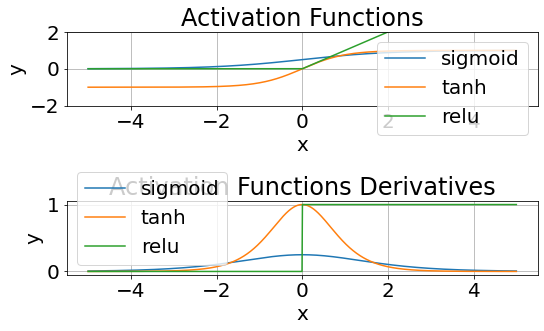

In [5]:
plot_activations()

Some reasons people cite for using ReLU are:

- Does not suffer from vanishing gradient when $x$ is far from zero (though gradient can still be zero).

- Much faster to compute than sigmoid and tanh.

- Promotes sparse weight vectors: "dead neurons" arguably cause sparsity in the next layer.

## ceate a function with MLP
---

<center><img src="imgs/mlp2.png" width=1000 /></center>
here we notate $\vec{y}_i$ as $\vec{z}_i$

one fun way of thinking would be, why do we use the activision function in each layer?

well, if we wouldn't, we could do something very fun..

le'ts look at MLP with one hidden layer:

$$
\hat{y} =\mat{W}_2~ \underbrace{\mathrm{relu}(\overbrace{\mat{W}_1 \vec{x}+ \vec{b}_1}^{\vec{z}})}_{\vec{a}} + \vec{b}_2,
$$

if we didn't use activision function, we had 

$$
\hat{y} =\mat{W}_2~ \underbrace{(\overbrace{\mat{W}_1 \vec{x}+ \vec{b}_1}^{\vec{z}})}_{\vec{a}} + \vec{b}_2,
$$

remember that the matrix dims are
$\mat{W}_l\in\set{R}^{n_{l}\times n_{l-1}},~ \vec{b}_l\in\set{R}^{n_l},~ l \in \{1,2,\dots,L\}.$

so instead of a complex model with 2 matrices of W and 2 biases,

we could have:
$$
\hat{y} =\mat{W}_2~ (\mat{W}_1 \vec{x}+ \vec{b}_1) + \vec{b}_2 = \mat{W}_3 \vec{x}+ \vec{b}_3 + \vec{b}_2 = \mat{W}_3 \vec{x}+ \vec{b}_4 
$$
where
$$
\mat{W}_3 = \mat{W}_2 \mat{W}_1 \\
\vec{b}_3 = \mat{W}_2 \vec{b}_1 \\
\vec{b}_4 = \vec{b}_3 + \vec{b}_2
$$



that could be great for us, as we can quntize all layers without non-linear activision to be a one layer. but then we can't express non-linear functions.

more then that, if we did so, we could say that after the multiplications, we have a more compact set of weights that we could optimize them from the begining...

essentially, what we say is that for each learnable layer that you use another layer after and no-activisions, you're just making the optimization process harder, as you could not use this layer and have the same model.

a word about `activision` and `bias`

Now, why is it so important to use those activisions? we said that we could represent any function in the world... we already know from furierr theory and laplace teory that with exponents we can represent any function.

moreover, bias sound like a small correction, but it's a learnable vector of how to modify our input, so let's demonstrate with some example:


assume you want to learn this function (of a singular input) with MLP:
<center><img src="imgs/fun1.PNG" width=800 /></center>


this is not homework in ML course, we we will give the solution

<center><img src="imgs/fun2.PNG" width=800 /></center>


and in math notation:

$h_{1,1} = relu(x+1)$

$h_{1,2} = relu(x+1)$

$h_{1,3} = relu(x-1)$

$h_{2} = z_1 - 2z_2 + 2z_3$

 


## Two-layer MLP implementation
---

Let's solve a simple **regression** problem with a 2-layer MLP (one hidden layer, one output layer).

We're trying to learn a continuous and perhaps non-deterministic function $y=f(\vec{x})$.

- Domain: $\vec{x}^i \in \set{R}^{D_{\text{in}}}$

- Target: $y^i \in \set{R}^{D_{\text{out}}}$

- Model: $\hat{y} =\mat{W}_2~ \varphi(\mat{W}_1 \vec{x}+ \vec{b}_1) + \vec{b}_2$<br>
  i.e. a 2-layer MLP, where:
    - $\vec{x}\in\set{R}^{D_{\text{in}}}$ sample (feature vector)
    - $\mat{W}_1\in\set{R}^{H\times D_{\text{in}}},\ \vec{b}_1\in\set{R}^{H}$
    - $\mat{W}_2\in\set{R}^{D_{\text{out}}\times H},\ \vec{b}_2\in\set{R}^{D_{\text{out}}}$
    - $\varphi(\cdot) = \mathrm{ReLU}(\cdot) = \max\{\cdot,0\}$
    - $H$ is the hidden dimension
    - We'll set $D_{\text{out}}=1$ so output is a scalar
   

 
- MSE loss with L2 regularization:
    $$
    \begin{align}
    \ell(\vec{y},\vec{\hat y}) &= \frac{1}{2}\norm{\vec{\hat y} - \vec{y}}^2 \\
    L_{\mathcal{S}} &= \frac{1}{N}\sum_{i=1}^{N}\ell(\vec{y},\vec{\hat y}) + \frac{\lambda}{2}\left(\norm{\mat{W}_1}_F^2 + \norm{\mat{W}_2}_F^2 \right)
    \end{align}
    $$
- Optimization scheme: Vanilla SGD

### Computing the loss gradients with backpropagation

Let's write our model as 
$$
\hat{y} =\mat{W}_2~ \underbrace{\mathrm{relu}(\overbrace{\mat{W}_1 \vec{x}+ \vec{b}_1}^{\vec{z}})}_{\vec{a}} + \vec{b}_2,
$$

and manually derive the gradient of the point-wise loss $\ell(\vec{y},\vec{\hat y})$ using the **chain rule**.
Remember that to use SGD, we need the gradient of the loss w.r.t. our parameter tensors.

$$
\begin{align}
&\pderiv{\ell}{\vec{\hat y}}=2\cdot\frac{1}{2}(\vec{\hat y}-\vec{y}) = (\vec{\hat y}-\vec{y})\\
(\ast)~~&\pderiv{\ell}{\mat{W}_2}= \pderiv{\ell}{\vec{\hat y}}\pderiv{\vec{\hat y}}{\mat{W}_2}
=(\vec{\hat y}-\vec{y})\vectr{a}
\end{align}
$$

How do we continue into the nonlinearity? Recall that we defined

$$ \pderiv{\mathrm{relu}(x)}{x} = \begin{cases} 1, & x\geq0 \\ 0, & x<0 \end{cases} $$

and that we apply the non-linearity elementwise on input tensors.

Also remember that the gradient of a vector w.r.t. another vector is the Jacobian, a matrix of mixed derivatives:
$\pderiv{a_i}{z_j}$.

We have $\vec{a}=\mathrm{relu}(\vec{z})$. Thus,

$$
\pderiv{\vec{a}}{\vec{z}}=\mathrm{diag}(\mathbb{1}[\vec{z}>0]).
$$


And so,
$$
\begin{align}
&\pderiv{\ell}{\vec{a}}=\pderiv{\vec{\hat y}}{\vec{a}}\pderiv{\ell}{\vec{\hat y}}
=\mattr{W}_2(\vec{\hat y}-\vec{y})\\
&\pderiv{\ell}{\vec{z}}=\pderiv{\vec{a}}{\vec{z}}\pderiv{\ell}{\vec{a}}
=\mathrm{diag}(\mathbb{1}[\vec{z}>0])\mattr{W}_2(\vec{\hat y}-\vec{y})\\
(\ast)~~&\pderiv{\ell}{\mat{W}_1}=\pderiv{\ell}{\vec{z}}\pderiv{\vec{z}}{\mat{W}_1}
=\mathrm{diag}(\mathbb{1}[\vec{z}>0])\mattr{W}_2(\vec{\hat y}-\vec{y})\vectr{x}\\
\end{align}
$$

For the biases, we can easily see that:
$$
\begin{align}
(\ast)~~&\pderiv{\ell}{\vec{b}_2}=\pderiv{\vec{\hat y}}{\vec{b}_2}\pderiv{\ell}{\vec{\hat y}}
=I_{D_{\text{out}}} \pderiv{\ell}{\vec{\hat y}} \\
(\ast)~~&\pderiv{\ell}{\vec{b}_1}=\pderiv{\vec{z}}{\vec{b}_1}\pderiv{\ell}{\vec{z}}
=I_{H}\pderiv{\ell}{\vec{z}}\\
\end{align}
$$

The final gradients for weight update, including regularization will be

$$
\nabla_{\mat{W}_j}L_{\mathcal{S}}=\frac{1}{N}\sum_{i=1}^{N} \pderiv{\ell_i}{\mat{W}_j} + \lambda\mat{W}_j, \ j=1,2.
$$

Let's implement it from scratch using just `numpy`.

In [6]:
# A simple MLP with one hidden layer

# N: batch size
# D_in: number of features
N, D_in =  64, 10
# H: hidden-layer
# D_out: output dimension
H, D_out =  100, 1

# Random input data
X = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Model weights and biases
wstd = 0.01
W1 = np.random.randn(H, D_in)*wstd
b1 = np.random.randn(H,)*wstd + 0.1
W2 = np.random.randn(D_out, H)*wstd
b2 = np.random.randn(D_out,)*wstd + 0.1

reg_lambda = 0.5
learning_rate = 1e-3

In [7]:
losses = []
for epoch in range(250):
    # Forward pass, hidden layer: A = relu(X W1 + b1), Shape: (N, H)
    Z = X.dot(W1.T) + b1
    A = np.maximum(Z, 0)
    
    # Forward pass, output layer: Y_hat = A W2 + b2, Shape: (N, D_out)
    Y_hat = A.dot(W2.T) + b2
    
    # Loss calculation (MSE)
    loss = np.mean((Y_hat - y) ** 2); losses.append(loss) # (N, D_out)
    
    # Backward pass:  Output layer
    d_Y_hat = (1./N) * (Y_hat - y)     # (N, D_out)
    d_W2 = d_Y_hat.T.dot(A)            # (D_out, H)
    d_A = d_Y_hat.dot(W2)              # (N, H)
    d_b2 = np.sum(d_Y_hat, axis=0)     # (D_out,)
    
    # Backward pass: Hidden layer
    d_Z = d_A * np.array(Z > 0, dtype=float)  # (N, H)
    d_W1 = d_Z.T.dot(X)                          # (H, D_in)
    d_b1 = np.sum(d_Z, axis=0)                   # (H,)
    
    # Backward pass: Regularization term
    d_W2 += reg_lambda * W2
    d_W1 += reg_lambda * W1
    
    # Gradient descent step
    W2 -= d_W2 * learning_rate; b2 -= d_b2 * learning_rate
    W1 -= d_W1 * learning_rate; b1 -= d_b1 * learning_rate
    print(epoch+1, end=' ')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 

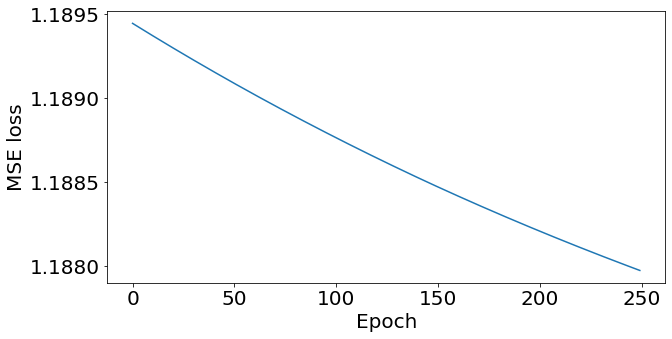

In [8]:
# Plot losses
_, ax = plt.subplots(figsize=(10,5))
ax.plot(losses)
ax.set_ylabel('MSE loss'); ax.set_xlabel('Epoch');

Note that this implementation is not ideal, as it's:

- Non modular (hard to switch components)
- Hard to extend (e.g. to add layers)
- Error prone (hard-coded manual calculations)

And now, we'll see how to address these issues using PyTorch's API.

##  N-Layer MLP using PyTorch
---

Let's create all our usual components:
- Dataset
- Model
- Loss function
- Optimizer

But this time we'll create a modular implementation where each of these components is separate and can be changed independently of the others.

### Dataset

As in the first tutorial we're goint to use  MNIST database of handwritten digits.

In [9]:
import torch
import torch.utils.data
import torchvision #for dataset
import torchvision.transforms as tv_transforms 

root_dir = os.path.expanduser('~/.pytorch-datasets/')

In [10]:
tf_tensor = tv_transforms.ToTensor()

batch_size = 512
train_size = batch_size * 10
test_size = batch_size * 2

# Datasets and loaders
ds_train = torchvision.datasets.MNIST(root=root_dir, download=True, train=True, transform=tf_tensor)
ds_test =  torchvision.datasets.MNIST(root=root_dir, download=True, train=False, transform=tf_tensor)


dl_train = torch.utils.data.DataLoader(ds_train, batch_size,
                                       sampler=torch.utils.data.SubsetRandomSampler(range(0,train_size)))
dl_test = torch.utils.data.DataLoader(ds_test, batch_size,
                                       sampler=torch.utils.data.SubsetRandomSampler(range(0,test_size)))

x0, y0 = ds_train[0]
n_features = torch.numel(x0)
n_classes = 10

print(f'x0: {x0.shape}, y0: {y0}')

x0: torch.Size([1, 28, 28]), y0: 5


x0: torch.Size([1, 28, 28]), y0: 5


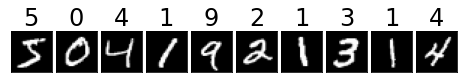

In [11]:
import sys
sys.path.append('..')
import T1.plot_utils as plot_utils
# Show first few samples
print(f'x0: {x0.shape}, y0: {y0}')
plot_utils.dataset_first_n(ds_train, 10, cmap='gray', show_classes=True);

### Model Implementation

- The `torch.nn` module contains building blocks such as neural network layers,
  loss functions, activations and more.
- In this section, we'll see various parts of the `torch.nn` API.
- We'll use `nn.Linear` which implements a single MLP layer.
- We'll implement our model as a subclass of `nn.Module`, which means:
    - Any tensors we set as properties will be registered as model parameters.
    - We can nest `nn.Modules` and get all model parameters from the top-level `nn.Module`.
    - Can be used as a function if we implement the `forward()` method.

To understand `nn.Module`, lets look at a very basic one: the [**fully-connected**](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer.

In [12]:
import torch.nn as nn

fc = nn.Linear(in_features=3, out_features=5, bias=True)

# 10 samples of 3 features
t = torch.randn(10, 3)

print(f'w: {fc.weight.shape} \nb: {fc.bias.shape}')

# Forward pass, notice that grad_fn exists
print(f'output {fc(t).shape}')
fc(t)

w: torch.Size([5, 3]) 
b: torch.Size([5])
output torch.Size([10, 5])


tensor([[-0.2845,  0.2501, -0.1356,  0.1289, -0.0985],
        [ 0.0745,  0.6346, -1.2990, -0.2640, -0.7732],
        [ 0.2629,  0.3942, -0.8706, -0.7141, -0.9265],
        [ 0.2376,  0.0940, -0.1527, -0.5201, -0.4389],
        [ 0.7591, -0.2891,  0.3530, -0.6938, -0.0777],
        [-0.4175,  0.4670, -0.5351, -0.2827, -0.7649],
        [ 0.2646,  0.2808, -0.6120, -0.4198, -0.5187],
        [ 0.3480, -0.0863,  0.1714,  0.2539,  0.5456],
        [-0.2826,  0.0870,  0.2471, -0.0189, -0.0816],
        [-0.9074,  0.4458, -0.1236,  0.1463, -0.4566]],
       grad_fn=<AddmmBackward>)

`nn.Modules` have registered **parameters**, which are tensors which `require_grad`.

In [13]:
# Note parameter dimenstions
list(fc.parameters())

[Parameter containing:
 tensor([[ 0.2730,  0.0484, -0.4255],
         [-0.1319, -0.1516, -0.0656],
         [ 0.1011,  0.3209,  0.4693],
         [ 0.0722, -0.1560,  0.2997],
         [ 0.2828,  0.0105,  0.2425]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1362,  0.2407, -0.4235, -0.3026, -0.3985], requires_grad=True)]

We can create custom `nn.Module`s with arbitrary logic. 

Let's recreate a fully-connected layer ourselves:

In [14]:
class MyFullyConnectedLayer(nn.Module):
    
    def __init__(self, in_features, out_features,bias=True):
        super().__init__() # don't forget this to inherent from nn.Module
        self.bias = bias
        # nn.Parameter just marks W,b for inclusion in list of parameters
        self.W = nn.Parameter(torch.randn(out_features, in_features, requires_grad=True))
        if self.bias:
            self.b = nn.Parameter(torch.randn(out_features, requires_grad=True))
                
    def forward(self, x):
        # x assumed to be (N, in_features)
        z = torch.matmul(x, self.W.T) 
        if self.bias:
            z+= self.b
        return z

In [15]:
myfc = MyFullyConnectedLayer(in_features=3, out_features=5)

In [16]:
myfc(t)

tensor([[ 0.3321,  1.3101, -2.6998, -2.4024,  3.5277],
        [ 2.1238,  1.2073, -3.4486, -2.1502, -1.8029],
        [ 1.8333,  0.6354, -1.4190,  1.1150, -4.3340],
        [ 0.6007,  0.7535, -0.1058,  2.0324, -0.9300],
        [-0.4182,  0.7467,  3.2832,  6.1788,  0.1734],
        [ 1.4934,  0.7424, -3.8291, -2.6588, -1.5390],
        [ 1.1283,  0.9889, -1.0591,  0.7976, -1.0397],
        [-0.8361,  1.8123,  0.5110,  0.8824,  7.1833],
        [-0.0582,  1.0418, -1.7586, -1.0589,  3.1049],
        [ 0.8704,  0.9493, -5.2797, -5.3564,  1.9541]], grad_fn=<AddBackward0>)

In [17]:
list(myfc.parameters())

[Parameter containing:
 tensor([[-0.4792, -0.3346, -0.6215],
         [ 0.2471, -0.2397,  0.0607],
         [ 1.3051,  1.0067, -0.9659],
         [ 1.2895,  1.4464, -1.8601],
         [ 1.6681, -0.5136,  2.6390]], requires_grad=True),
 Parameter containing:
 tensor([ 0.8429,  1.0350, -1.2680,  0.2599,  0.1117], requires_grad=True)]

Quick visualization of our custom module's **computation graph**:

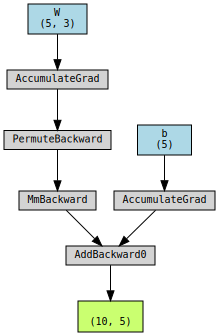

In [18]:
import torchviz
torchviz.make_dot(myfc(t), params=dict(W=myfc.W, b=myfc.b))

Now that we know about `nn.Module`s, lets create an fairly-general MLP for multiclass classification.

In [19]:
class MLP(nn.Module):
    NLS = {'relu': torch.nn.ReLU, 'tanh': nn.Tanh, 'sigmoid': nn.Sigmoid, 'softmax': nn.Softmax, 'logsoftmax': nn.LogSoftmax}

    def __init__(self, D_in: int, hidden_dims: Sequence[int], D_out: int, nonlin='relu'):
        super().__init__()
        
        all_dims = [D_in, *hidden_dims, D_out]
        non_linearity = MLP.NLS[nonlin]
        layers = []
        
        for in_dim, out_dim in zip(all_dims[:-1], all_dims[1:]):
            layers += [
                nn.Linear(in_dim, out_dim, bias=True),
                non_linearity()
            ]
        
        self.fc_layers = nn.Sequential(*layers[:-1])
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], -1)) #flatten x
        z = self.fc_layers(x)
        y_pred = self.log_softmax(z)
        # Output is always log-probability
        return y_pred

In [20]:
# Create an instance of the model: 5-layer MLP
mlp5 = MLP(D_in=n_features, hidden_dims=[32, 64, 128, 64], D_out=n_classes, nonlin='tanh')

print(mlp5)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)


In [21]:
print(f'number of parameter tensors: {len(list(mlp5.parameters()))}')

number of parameter tensors: 10


In [22]:
print(f'number of parameters: {np.sum([torch.numel(p) for p in mlp5.parameters()])}')

number of parameters: 44458


In [23]:
# Test a forward pass
y_hat0 = mlp5(x0)

print(f'{x0.shape=}\n')
print(f'{y_hat0.shape=}\n')
print(f'{y_hat0=}')

x0.shape=torch.Size([1, 28, 28])

y_hat0.shape=torch.Size([1, 10])

y_hat0=tensor([[-2.2445, -2.3043, -2.1575, -2.3291, -2.4427, -2.4495, -2.3029, -2.1782,
         -2.4060, -2.2581]], grad_fn=<LogSoftmaxBackward>)


Quick visualization of our full MLP's **computation graph**:

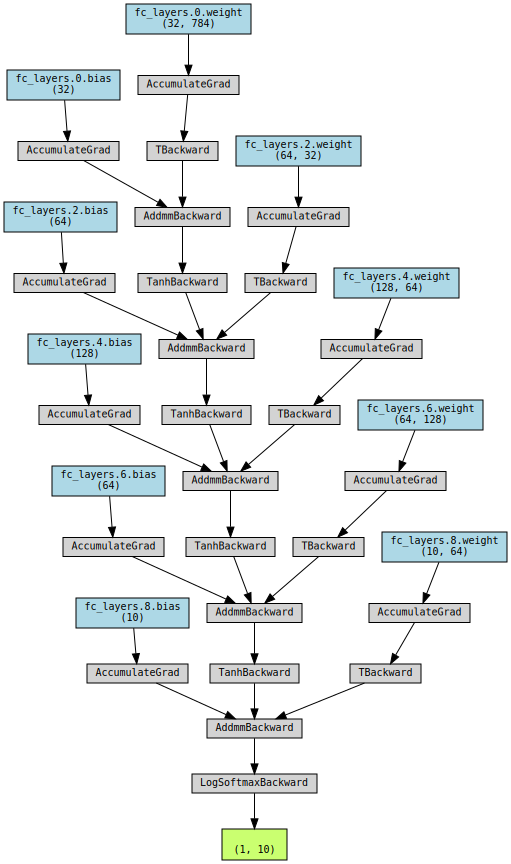

In [24]:
torchviz.make_dot(mlp5(x0), params=dict(mlp5.named_parameters()))

### Loss and Optimizer

For the loss function, we'll use PyTorch's built in negative log-likelihood loss since our model outputs probabilities.

Log Softmax is advantageous over softmax for numerical stability, optimisation and heavy penalisation for highly incorrect class

softmax for first class:
$$
\frac{e^{w_1x_1}}{\sum_i{e^{w_ix_i}}}
$$
log softmax for first class:
$$
\frac{log(e^{w_1x_1})}{log(\sum_i{e^{w_ix_i}})} = \frac{log(e^{w_1x_1})}{\sum_i{log(e^{w_ix_i}})} =\frac{log(e^{w_1x_1})}{\sum_i{w_ix_i}}  
$$


In [25]:
Probability =  torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
Log_Probability = torch.log(Probability)
print(f'{Probability=}\n {Log_Probability=}')

Probability=tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000])
 Log_Probability=tensor([-2.3026, -1.6094, -1.2040, -0.9163, -0.6931, -0.5108, -0.3567, -0.2231,
        -0.1054,  0.0000])


In [26]:
import torch.optim

# Loss:
# Note: NLLLoss assumes *log*-probabilities (given by our LogSoftmax layer)
loss_fn = nn.NLLLoss()

# Fake ground-truth labels
# Notice that we don't need to 1-hot encode them!
yt = torch.randint(low=0, high=n_classes, size=(y_hat0.shape[0],))

# Try out the loss
loss_fn(y_hat0, yt)

tensor(2.3029, grad_fn=<NllLossBackward>)

As for the optimization scheme, we'll use a built in SGD optimizer from the `torch.optim` module.

We won't need to calculate the loss gradient this time, as we'll use `autograd` for automatic differentiation.

In [27]:
torch.manual_seed(42)

# Model for training
model = MLP(D_in=n_features, hidden_dims=[32, 32, 32], D_out=n_classes, nonlin='relu')

# Optimizer over our model's parameters
optimizer = torch.optim.SGD(params=model.parameters(), lr=5e-2, weight_decay=0.01, momentum=0.9)

### Training loop

This time we'll train over lazy-loaded batches from our data loader.

Notice that except from our model's `__init__()` and `__forward()__`, we're using PyTorch facilities for the entire training implementation.

In [28]:
num_epochs = 20
losses_mlp = []
for epoch_idx in range(num_epochs):
    total_loss = 0
    
    for batch_idx, (X, y) in enumerate(dl_train):
        # Forward pass
        y_pred = model(X) #btz x channels x input_w x input_h --> btz x num_classes

        # Compute loss
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()
        losses_mlp.append(loss.item())
        
        # Backward pass
        optimizer.zero_grad() # Zero gradients of all parameters
        loss.backward()       # Run backprop algorithms to calculate gradients
        
        # Optimization step
        optimizer.step()      # Use gradients to update model parameters
        
    print(f'Epoch #{epoch_idx+1}: Avg. loss={total_loss/len(dl_train)}')

Epoch #1: Avg. loss=2.3051342964172363
Epoch #2: Avg. loss=2.2864507913589476
Epoch #3: Avg. loss=2.256749725341797
Epoch #4: Avg. loss=2.176988196372986
Epoch #5: Avg. loss=1.9311089277267457
Epoch #6: Avg. loss=1.416105616092682
Epoch #7: Avg. loss=0.9191413521766663
Epoch #8: Avg. loss=0.6763408541679382
Epoch #9: Avg. loss=0.561395674943924
Epoch #10: Avg. loss=0.5014575719833374
Epoch #11: Avg. loss=0.4618980139493942
Epoch #12: Avg. loss=0.40606015622615815
Epoch #13: Avg. loss=0.3734510004520416
Epoch #14: Avg. loss=0.36528579890727997
Epoch #15: Avg. loss=0.33605656325817107
Epoch #16: Avg. loss=0.32324054539203645
Epoch #17: Avg. loss=0.3065242201089859
Epoch #18: Avg. loss=0.30083635449409485
Epoch #19: Avg. loss=0.28492291569709777
Epoch #20: Avg. loss=0.2703426152467728


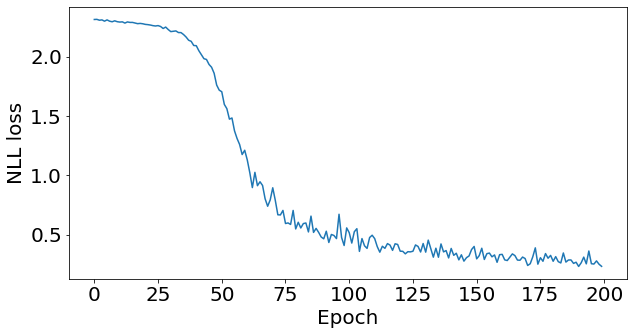

In [29]:
# Plot losses
_, ax = plt.subplots(figsize=(10,5))
ax.plot(losses_mlp)
ax.set_ylabel('NLL loss'); ax.set_xlabel('Epoch');

Using the basic PyTorch building blocks we have arrived at a much more robust implementation:
- Easy to change architecture: layers and activation functions
- Easy to change loss
- Easy to change optimization method
- No need for manual gradient derivations

## Further reading
---

### initialization

We saw today a FC layer (or MLP or Linear layer), Neural networks has other type of layers that we're going to see in the next couple of tutorials.

when we implemented it ourself, we used torch.randn, that widraw from the standart normal distribution $\mathcal{N}(0,1)$.

But why? or more important, since we optimize it, **why does it matter**?

The answer to the second questioin is quite simple. just like K-Means, Neural network is not a stable algorithem, since diffrent initilizations will bring a diffrent outcome.<br>
why is that? remember that the loss function is not a simple convex function!<br> if we start with diffrent initilizations we're probably going to end up at diffrent local minima.

**note** that i'm lying to you a little bit, since we usually use Batch optimization algorithms and diffrent batches already contain a little randomness so even if the initial point is the same, we're not going to get the same trajectory from them on the loss function, and therfore this problem might not exist... 

The honest answer is that this is an active research topic and the jastifications adressing some isues that we will state here, but it's not a rigorous definition.

Intuitivly, first thing we would think of a constant value, like 0 for all weights.

The idea of no constant is to:
* accelerate training by using small values
* keep neumerical stability
* brake symmetry

Other problem that we did not adress yet, is that with long networks, the chain rule is pruned make the gradients too small or too big (**vanishing gradients** and **exploding gradients** respectively). 

So what can we do if we want to sqeeze the best results we can?

#### Xavier
Briefly, Normal distribution is always a good start, and to avoid edges effect normelize with the input size would help.
however, activision functions turn to non-linear shift in distibusion in neural networks.

that's where **Xavier initilization** came to life in [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

basically they did a uniform distibution in [-1,1] and then scaling by $\frac{1}{\sqrt{n}}$.

:
<img src="imgs/no_x_grads.png" width=600 />
<img src="imgs/x_grads.png" width=600 />

here you can see the gradients without xavier (left) and with xavier (right)


note that we can use this normalization with $~\mathcal(N)$ or $~\mathcal(U)$ 

* **Xavier Uniform** - Initialize with values using uniform distribution. The resulting tensor will have values sampled from $\mathcal{U}(-a, a)$ where $$ a = \text{gain} \times \sqrt{\frac{6}{\text{fan}_{in} + \text{fan}_{out}}} $$
    
    
    
    
* **Xavier ** - Initialize with values using a normal distribution. The resulting tensor will have values sampled from $\mathcal{N}(0,\text{std}^2)$ where $$ \text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan}_{in} + \text{fan}_{out}}} $$


* `fan_in` is the number of input units in the weight tensor and `fan_out` is the number of output units in the weight tensor

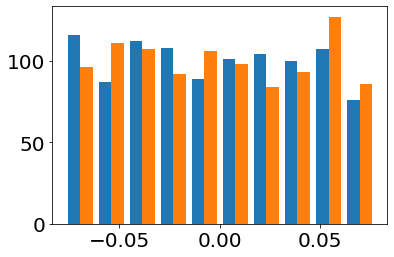

In [30]:
w = torch.empty(2, 1000)
xavier_u = torch.nn.init.xavier_uniform_(w, gain=1.0)
plt.hist(xavier_u);

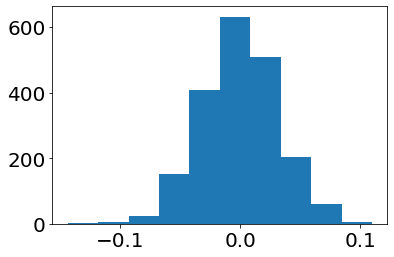

In [31]:
w = torch.empty(1, 2000)
xavier_n = torch.nn.init.xavier_normal_(w, gain=1.0)
plt.hist(xavier_n);

One more improvment is **Kaiming Initialization** from [Delving Deep into Rectifiers:
Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852.pdf).<br>
The only diffrence is that modern neural networks usually use Relu, or other type of non-symetric activision functions.<br>
we won't go into the math of the paper, but the only noticeble diffrence is that we scale by  $\frac{\sqrt{2}}{\sqrt{n}}$.


* **Kaiming  Uniform** - The resulting tensor will have values sampled from $\mathcal{U}(-\text{bound}, \text{bound})$ where $$ \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan_mode}}} $$

    
* **Kaiming (He) Normal** - Initialize with values sampled from normal distribution. The resulting tensor will have values sampled from $\mathcal{N}(0,\text{std}^2)$ where $$ \text{std} = \frac{\text{gain}}{\sqrt{\text{fan_mode}}} $$
    
    * `fan_mode` – either `fan_in` (default) or `fan_out`. Choosing `fan_in` preserves the magnitude of the variance of the weights in the forward pass. Choosing `fan_out`

and ever since, this is part of the Pytorch NN package.


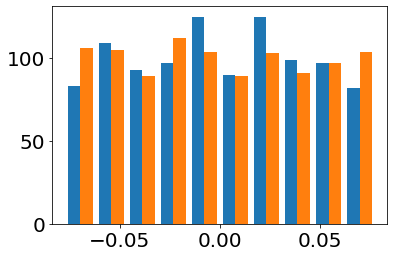

In [32]:
#`nonlinearity` – the non-linear function (`nn.functional` name), recommended to use only with `relu` or `leaky_relu` (default).
w = torch.empty(2, 1000)
k_u = torch.nn.init.kaiming_uniform_(w, a=0, mode='fan_in', nonlinearity='relu')
plt.hist(k_u);

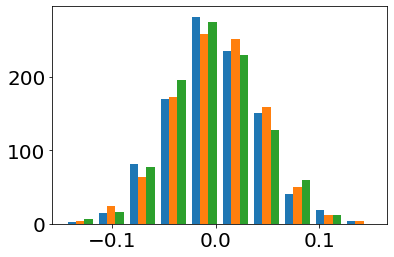

In [33]:
w = torch.empty(3, 1000)
k_n = torch.nn.init.kaiming_normal_(w, a=0, mode='fan_in', nonlinearity='relu')
plt.hist(k_n);

Note that initilization work for each channel seperatly

If we would like to change back to Xavier from kaiming (mostly, since there is no noticable diffrence for layers without ReLU)

In [34]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
model.apply(weights_init)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

when we use diffrent activisions, or when we do non-standart work, we might consider Xavier or something else...

thank you

## Links
---
[3b1b backprop video](https://www.youtube.com/watch?v=Ilg3gGewQ5U&ab_channel=3Blue1Brown)

[advanced loss functions](https://www.kdnuggets.com/2019/11/research-guide-advanced-loss-functions-machine-learning-models.html)

[how to choose loss functions](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

[Weight Initialization in Neural Networks: A Journey From the Basics to Kaiming](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

## Credits
---

This tutorial heavly based on [Technion IIT cs-236781 tutorial](https://github.com/vistalab-technion/cs236781-tutorials/blob/master/t03/tutorial3-MLP.ipynb) that written by [Aviv Rosenberg](https://avivr.net) and re-weitten by [Moshe Kimhi](https://www.linkedin.com/in/moshekimhi/)<br>
To re-use, please provide attribution and link to the original.

Some images in this tutorial were taken and/or adapted from the following sources:

- MartinThoma [CC0], via Wikimedia Commons https://commons.wikimedia.org/wiki/File:Perceptron-unit.svg
- Pattern Recognition and Machine Learning, C. M. Bishop, Springer, 2006
- Sebastian Raschka https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html
- Favio Vázquez https://towardsdatascience.com/a-conversation-about-deep-learning-9a915983107
- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017